In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [3]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


**ImageDataset**  
以下の様に変更  
画像サイズを256×256  
(B,C,H,W)  
torch.FloatTensor[0.0, 1.0]  
μ=0.5, Σ=0.5で標準化 → [-1.0, 1.0]  

In [5]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch_from = torch.stack([
    data[4]['img'],
    data[5]['img']
])
batch_to = torch.stack([
    data[0]['img'],
    data[1]['img'],
    data[2]['img'],
    data[3]['img']
])

**permute([1,2,0])/2+0.5**  
次元操作(H,W,C)に変換  
[0, 1]にスケーリング

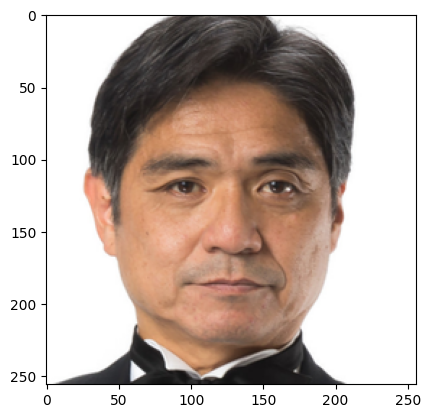

In [6]:
import matplotlib.pyplot as plt
plt.imshow(batch_from[0].permute([1, 2, 0])/2 + 0.5)

In [11]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
cls_model.to(device);

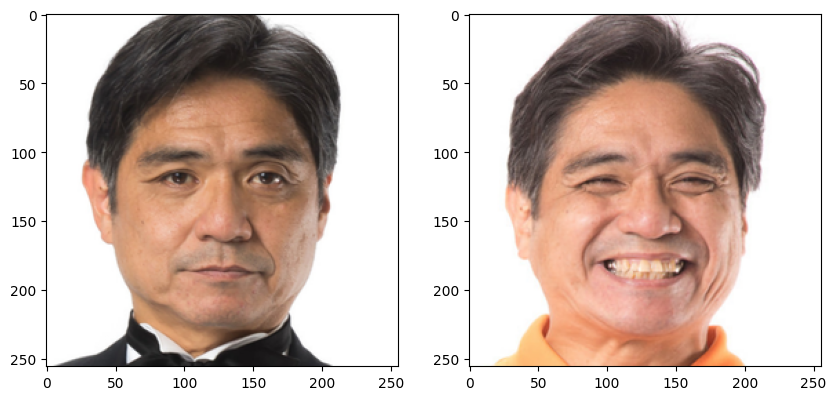

In [81]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(batch_from[0].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch_from[1].permute([1, 2, 0]) / 2 + 0.5)
# plt.savefig('imgs_test_out/change_compare1.png')

# Encode

In [61]:
cond_to = model.encode(batch_to.to(device))
cond_to_norm = cls_model.normalize(cond_to)
xT = model.encode_stochastic(batch_to.to(device), cond_to, T=250)

cond_from = model.encode(batch_from.to(device))
cond_change = cond_from[1] - cond_from[0]
cond2 = cond_to_norm + 0.3 * math.sqrt(512) * F.normalize(cond_change[None, :])
cond2 = cls_model.denormalize(cond2)

In [67]:
xT.shape

torch.Size([4, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


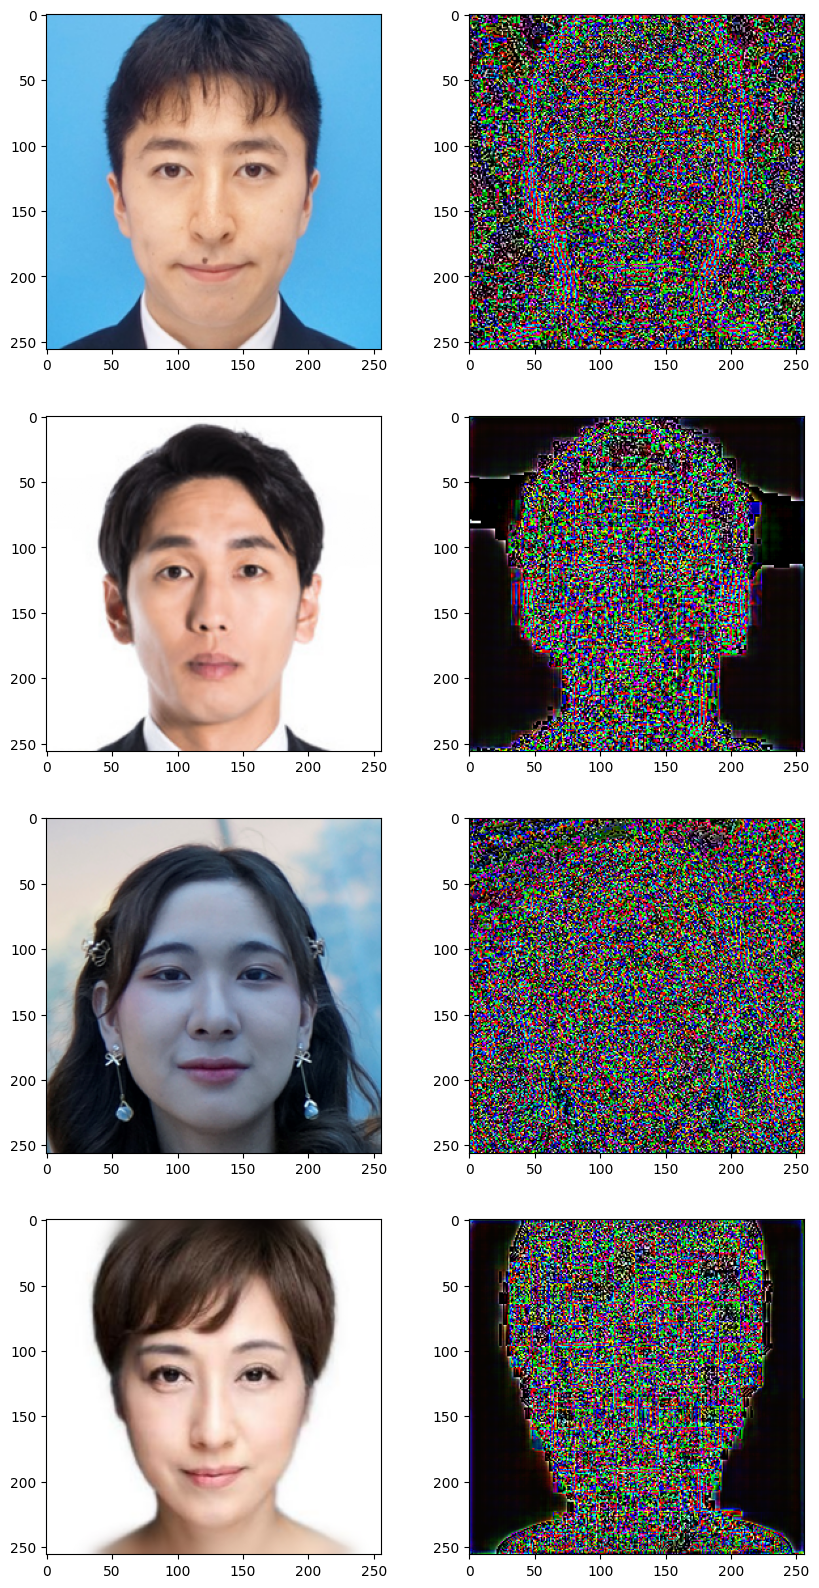

In [80]:
import matplotlib.pyplot as plt
num_xT = len(xT)
fig, ax = plt.subplots(num_xT, 2, figsize=(10, 5*num_xT))
ori = (batch_to + 1) / 2
for i in range(num_xT):
    ax[i,0].imshow(ori[i].permute(1, 2, 0).cpu())
    ax[i,1].imshow(xT[i].permute(1, 2, 0).cpu())
# plt.savefig('imgs_test_out/forward_compare1.png')

# Decode

In [75]:
pred = model.render(xT, cond2, T=20)

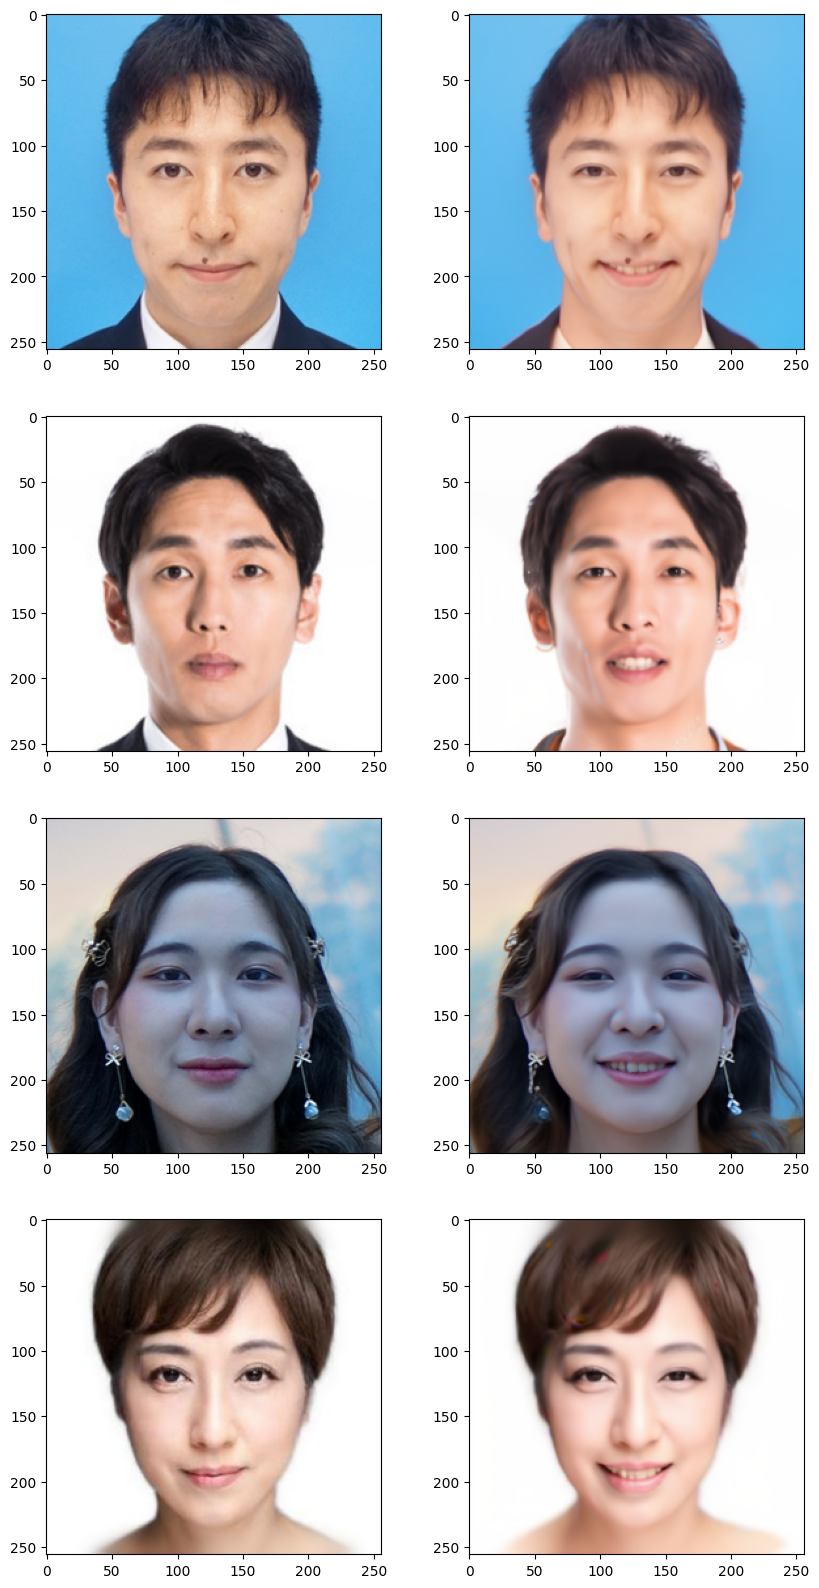

In [82]:
# num_xT = len(xT)
fig, ax = plt.subplots(num_xT, 2, figsize=(10, 5*num_xT))
# ori = (batch_to + 1) / 2
for i in range(num_xT):
    ax[i,0].imshow(ori[i].permute(1, 2, 0).cpu())
    ax[i,1].imshow(pred[i].permute(1, 2, 0).cpu())
# plt.savefig('imgs_test_out/transfer_compare1.png')